"""
Copyright 2026 Zsolt Bedőházi

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, f1_score, auc
from sklearn.metrics import auc as calc_auc, precision_recall_curve, average_precision_score, precision_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import random
import glob
import h5py
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import to_rgba
from matplotlib.colors import LinearSegmentedColormap
from omegaconf import OmegaConf
from omegaconf import DictConfig
from sklearn.preprocessing import label_binarize

import warnings
import copy
import seaborn as sns

In [ ]:
conf_preproc = OmegaConf.load("../../../conf/preproc.yaml")
conf_preproc = conf_preproc["project_mil"]

run_nr = "run_sote_sqrt_paper_rev_tuned"
conf_train = OmegaConf.load(f"<YOUR_PATH>/03_training/sote_finetuned_uni_224_224_patches_paper_patients_rev/runs/{run_nr}/experiment_0/conf_train.yaml")

In [3]:
if torch.cuda.is_available():
    DEVICE = 'cuda:0' 
else:
    DEVICE = 'cpu'
print("Device:", DEVICE)

Device: cuda:0


## VALIDATION FOLDS

### Load input

In [ ]:
conf_train["cv_split_dir"]

In [ ]:
# Load predictions
preds_val_folds = np.load('../../../04_prediction/classic_mil/sote_paper_patients_rev_tuned/preds_sote_5ensemble_level4_macenko_uni_finetuned_run_sote_sqrt_paper_rev_tuned_val_loss_val_folds_rev.npz')

In [6]:
list(preds_val_folds.keys())

['val_fold_0', 'val_fold_1', 'val_fold_2', 'val_fold_3', 'val_fold_4']

In [7]:
preds_val_folds['val_fold_0'][:3]

array([[0.59931093, 0.22363934, 0.17704976],
       [0.05234988, 0.35337234, 0.59427774],
       [0.48233888, 0.2851016 , 0.23255955]], dtype=float32)

In [8]:
m = 0
biopsy_df_val_current = pd.read_csv(f'{conf_train["cv_split_dir"]}val_split_multi_stratified_{m}.csv', dtype={"base_slide_number": str})
biopsy_df_val_current.sort_values('base_slide_number', inplace=True)

In [9]:
biopsy_df_val_current.clinical_stage.values[:3]

array([1, 3, 2])

### Calculate thresholds based on PR curves using all validation folds

In [10]:
def calculate_pr_curve_thresholds_for_valfolds(preds_val_folds, class_index):
    #base_recalls = np.linspace(0, 1, 101)
    precisions = []
    pr_aucs = [] # NOT interpolated, AUC of individual curves
        
    best_thresholds = [] # saving thresholds calculated for individual NOT interpolated curves !
    best_precisions = []
    best_recalls = []
    best_f1s = []
    
    for foldnum in range(5):
    
        # load current true labels
        biopsy_df_val_current = pd.read_csv(f'{conf_train["cv_split_dir"]}val_split_multi_stratified_{foldnum}.csv', dtype={"base_slide_number": str})
        biopsy_df_val_current.sort_values('base_slide_number', inplace=True)
        sample_y_true = biopsy_df_val_current.clinical_stage.values - 1

        # load current probability predictions
        sample_y_pred = preds_val_folds[f'val_fold_{foldnum}']
        #print(sample_y_true.shape, sample_y_pred.shape)
    
        # Binarize the true labels for one-vs-rest classification
        binarized_y_true = (sample_y_true == class_index).astype(int)
        
        # Calculate precision-recall curve
        precision, recall, threshold = precision_recall_curve(binarized_y_true, sample_y_pred[:, class_index])
        #print(threshold)
        
        pr_auc = auc(recall, precision) 
        pr_aucs.append(pr_auc)
        
        ## calculate f beta score to get best threshold
        # https://stats.stackexchange.com/questions/559736/is-there-a-metric-that-combines-recall-and-precision-other-than-the-f1-score
        beta = 1
        # THIS IS NOT interpolated: !!! (threshold calculation does not really need it)
        fscore = (1+beta**2) * precision*recall / (beta**2*precision + recall)

        # one way to get only max value:
        #fscore_max_idx = np.nanargmax(fscore) # locate the index of the largest f score

        # or other way: top X percentage
        fscore_max_idxs = (np.nanpercentile( fscore, 95 ) < fscore)

        ## save variables
        best_thresholds.append(threshold[fscore_max_idxs[:-1]]) #st.mode( f_score_max_idx_all, keepdims=False )[0]
        best_precisions.append(precision[fscore_max_idxs])
        best_recalls.append(recall[fscore_max_idxs])
        best_f1s.append(fscore[fscore_max_idxs])
        #print(fscore_max_idx)
        
        ## plot only for debugging
        #plt.plot(recall, precision, label=f'PRAUC = {pr_auc:.4f}')
        #plt.legend()
    
    return best_thresholds, best_f1s, best_precisions, best_recalls, pr_aucs

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    thresholds_final = []
    thresholds_final_std_err = []
    best_f1_final = []
    best_f1_final_std_err = [] 
    best_precision_final = []
    best_precision_final_std_err = [] 
    best_recall_final = []
    best_recall_final_std_err = []

    for current_class in range(3):
        best_thresholds_valfolds, best_f1s_valfolds, best_precisions_valfolds, best_recalls_valfolds, pr_aucs = calculate_pr_curve_thresholds_for_valfolds(preds_val_folds, current_class)
        #print(best_thresholds_valfolds)

        rounding = 3

        thresholds_concat = np.concatenate( best_thresholds_valfolds )
        thresholds_mean = np.round( np.mean(thresholds_concat), rounding )
        thresholds_std_error = np.round( np.std( thresholds_concat )/ np.sqrt(len(thresholds_concat)), rounding)

        best_f1s_concat = np.concatenate( best_f1s_valfolds )
        best_f1s_mean = np.round( np.mean(best_f1s_concat), rounding )
        best_f1s_std_error = np.round( np.std( best_f1s_concat )/ np.sqrt(len(best_f1s_concat)), rounding)

        best_precisions_concat = np.concatenate( best_precisions_valfolds )
        best_precisions_mean = np.round( np.mean(best_precisions_concat), rounding )
        best_precisions_std_error = np.round( np.std( best_precisions_concat )/ np.sqrt(len(best_precisions_concat)), rounding)

        best_recalls_concat = np.concatenate( best_recalls_valfolds )
        best_recalls_mean = np.round( np.mean(best_recalls_concat), rounding )
        best_recalls_std_error = np.round( np.std( best_recalls_concat )/ np.sqrt(len(best_recalls_concat)), rounding)

        thresholds_final.append(thresholds_mean)
        thresholds_final_std_err.append(thresholds_std_error)

        best_f1_final.append(best_f1s_mean)
        best_f1_final_std_err.append(best_f1s_std_error)

        best_precision_final.append(best_precisions_mean)
        best_precision_final_std_err.append(best_precisions_std_error)

        best_recall_final.append(best_recalls_mean)
        best_recall_final_std_err.append(best_recalls_std_error)

In [12]:
thresholds_final, thresholds_final_std_err, best_f1_final, best_f1_final_std_err, best_precision_final, best_precision_final_std_err, best_recall_final, best_recall_final_std_err

([np.float32(0.387), np.float32(0.29), np.float32(0.374)],
 [np.float64(0.018), np.float64(0.01), np.float64(0.033)],
 [np.float64(0.614), np.float64(0.711), np.float64(0.432)],
 [np.float64(0.019), np.float64(0.007), np.float64(0.011)],
 [np.float64(0.552), np.float64(0.609), np.float64(0.443)],
 [np.float64(0.041), np.float64(0.017), np.float64(0.049)],
 [np.float64(0.757), np.float64(0.873), np.float64(0.609)],
 [np.float64(0.036), np.float64(0.027), np.float64(0.076)])

In [13]:
def format_with_std_err(values, std_err):
    return [f"{value:.3f} +/- {err:.3f}" for value, err in zip(values, std_err)]

# Formatting the values with their standard errors
formatted_thresholds = format_with_std_err(thresholds_final, thresholds_final_std_err)
formatted_best_f1 = format_with_std_err(best_f1_final, best_f1_final_std_err)
formatted_best_precision = format_with_std_err(best_precision_final, best_precision_final_std_err)
formatted_best_recall = format_with_std_err(best_recall_final, best_recall_final_std_err)

print("Thresholds:            ", "   ".join(formatted_thresholds))
print("\nBest F1 scores:        ", "   ".join(formatted_best_f1))
print("Best Precision scores: ", "   ".join(formatted_best_precision))
print("Best Recall scores:    ", "   ".join(formatted_best_recall))

Thresholds:             0.387 +/- 0.018   0.290 +/- 0.010   0.374 +/- 0.033

Best F1 scores:         0.614 +/- 0.019   0.711 +/- 0.007   0.432 +/- 0.011
Best Precision scores:  0.552 +/- 0.041   0.609 +/- 0.017   0.443 +/- 0.049
Best Recall scores:     0.757 +/- 0.036   0.873 +/- 0.027   0.609 +/- 0.076


In [14]:
def give_back_hard_label_predictions_with_threshold_tuning(prob_pred_array, threshold_values):
    
    # Calculate the predicted labels for this set
    preds_threshold_tuned = np.copy(prob_pred_array) # final_pred_ensemble_local_test_macenko)

    filt_3 = (preds_threshold_tuned[:,2] > threshold_values[-1])
    preds_threshold_tuned[filt_3,:] = np.array([0,0,1]) # 1.0

    filt_2 = (preds_threshold_tuned[~filt_3,1] > threshold_values[-2])
    idxs_2 = np.arange( preds_threshold_tuned.shape[0] )[~filt_3][filt_2]
    preds_threshold_tuned[idxs_2,:] = np.array([0,1,0]) # 1.0

    
    predicted_labels = np.argmax(preds_threshold_tuned, axis=1)
    
    return predicted_labels

#### test if works

In [15]:
give_back_hard_label_predictions_with_threshold_tuning(preds_val_folds['val_fold_0'], thresholds_final)

array([0, 2, 0, 2, 0, 0, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1, 2, 1, 0, 1,
       1, 2, 0, 2, 1, 1, 2, 2, 1, 2, 0, 1, 2, 1, 0, 1, 1, 0, 2, 1, 1])

In [16]:
np.save('thresholds_sote_final_uni_finetuned_sote_sqrt_paper_rev.npy', thresholds_final)

### Cross-validation metrics (val folds)

In [17]:
# Initialize lists to store metric values
accuracy_values = []
f1_macro_values = []
f1_weighted_values = []
recall_macro_values = []
recall_weighted_values = []
precision_macro_values = []
precision_weighted_values = []
roc_auc_macro_values = []
roc_auc_weighted_values = []
ck_values = []
f1_classwise_values = []
recall_classwise_values = []
precision_classwise_values = []
pr_auc_macro_values = []
pr_auc_weighted_values = []

# Iterate over each fold
for i in range(5):
    val_df = pd.read_csv(f'{conf_train["cv_split_dir"]}val_split_multi_stratified_{i}.csv', dtype={"base_slide_number": str})
    val_df.sort_values('base_slide_number', inplace=True)  # Ensure matching order with predictions
    
    y_true = val_df.clinical_stage.values - 1  # Adjust y_true to be zero-based
    y_pred_proba = preds_val_folds[f'val_fold_{i}']
    #y_pred = np.argmax(y_pred_proba, axis=1)
    y_pred = give_back_hard_label_predictions_with_threshold_tuning(y_pred_proba, thresholds_final)
    
    # Check unique values in y_true and y_pred
    unique_true_classes = np.unique(y_true)
    unique_pred_classes = np.unique(y_pred)
    
    #print(f"Fold {i}: Unique true classes: {unique_true_classes}")
    #print(f"Fold {i}: Unique predicted classes: {unique_pred_classes}")

    # Check class distribution
    true_class_distribution = np.bincount(y_true, minlength=4)
    pred_class_distribution = np.bincount(y_pred, minlength=4)
    
    #print(f"Fold {i}: True class distribution: {true_class_distribution}")
    #print(f"Fold {i}: Predicted class distribution: {pred_class_distribution}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
    print(f"Confusion Matrix for Fold {i}:")
    print(cm)

    # Calculating TP, FP, FN for class 2
    TP_class2 = cm[2, 2]
    FP_class2 = cm[:, 2].sum() - TP_class2
    FN_class2 = cm[2, :].sum() - TP_class2

    #print(f"Class 2: TP={TP_class2}, FP={FP_class2}, FN={FN_class2}")

    # Overall metrics
    accuracy = accuracy_score(y_true, y_pred)
    accuracy_values.append(accuracy)
    
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    
    f1_macro_values.append(f1_macro)
    f1_weighted_values.append(f1_weighted)
    recall_macro_values.append(recall_macro)
    recall_weighted_values.append(recall_weighted)
    precision_macro_values.append(precision_macro)
    precision_weighted_values.append(precision_weighted)
    
    # ROC AUC and PR AUC (One-vs-Rest)
    y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])
    
    roc_auc_macro = roc_auc_score(y_true_binarized, y_pred_proba, average='macro', multi_class='ovr')
    roc_auc_weighted = roc_auc_score(y_true_binarized, y_pred_proba, average='weighted', multi_class='ovr')
    
    pr_auc_macro = average_precision_score(y_true_binarized, y_pred_proba, average='macro')
    pr_auc_weighted = average_precision_score(y_true_binarized, y_pred_proba, average='weighted')
    
    roc_auc_macro_values.append(roc_auc_macro)
    roc_auc_weighted_values.append(roc_auc_weighted)
    
    pr_auc_macro_values.append(pr_auc_macro)
    pr_auc_weighted_values.append(pr_auc_weighted)
    
    # Cohen's Kappa
    ck = cohen_kappa_score(y_true, y_pred, weights='quadratic')
    ck_values.append(ck)
    
    # Class-wise metrics
    f1_classwise = f1_score(y_true, y_pred, average=None, zero_division=0)
    recall_classwise = recall_score(y_true, y_pred, average=None, zero_division=0)
    precision_classwise = precision_score(y_true, y_pred, average=None, zero_division=0)
    
    #print(f"Fold {i} - Class-wise F1 Scores: {f1_classwise}")
    #print(f"Fold {i} - Class-wise Recall: {recall_classwise}")
    #print(f"Fold {i} - Class-wise Precision: {precision_classwise}")

    f1_classwise_values.append(f1_classwise)
    recall_classwise_values.append(recall_classwise)
    precision_classwise_values.append(precision_classwise)

# Aggregating metrics for reporting
metrics_dict = {
    'Accuracy': accuracy_values,
    'F1_Macro': f1_macro_values,
    'F1_Weighted': f1_weighted_values,
    'Precision_Macro': precision_macro_values,
    'Precision_Weighted': precision_weighted_values,
    'Recall_Macro': recall_macro_values,
    'Recall_Weighted': recall_weighted_values,
    'ROC_AUC_Macro': roc_auc_macro_values,
    'ROC_AUC_Weighted': roc_auc_weighted_values,
    #'CK': ck_values,
    'PR_AUC_Macro': pr_auc_macro_values,
    'PR_AUC_Weighted': pr_auc_weighted_values
}

Confusion Matrix for Fold 0:
[[ 6  6  1]
 [ 4  8 10]
 [ 0  3  5]]
Confusion Matrix for Fold 1:
[[ 4  7  0]
 [ 4 10  9]
 [ 2  4  3]]
Confusion Matrix for Fold 2:
[[ 7  5  1]
 [ 5 11  5]
 [ 2  6  1]]
Confusion Matrix for Fold 3:
[[ 7  3  3]
 [ 2 10  9]
 [ 2  3  4]]
Confusion Matrix for Fold 4:
[[ 6  6  1]
 [ 0 14  7]
 [ 0  5  3]]


In [18]:
# Calculate and print statistics for each metric
def calc_stats_for_metric(metric_values):
    mean_value = np.mean(metric_values)
    std_dev = np.std(metric_values, ddof=1)
    sem = std_dev / np.sqrt(len(metric_values))
    confidence_level = 0.95
    degrees_freedom = len(metric_values) - 1
    confidence_interval = stats.t.interval(confidence_level, degrees_freedom, mean_value, sem)
    print(f"Mean: {np.round(mean_value, 3)}")
    print(f"Standard Error: {np.round(sem, 3)}")
    print(f"95% CI: {np.round(confidence_interval, 3)}")

for metric_name, metric_values in metrics_dict.items():
    print(f"\n{metric_name}:")
    calc_stats_for_metric(metric_values)


Accuracy:
Mean: 0.463
Standard Error: 0.026
95% CI: [0.391 0.535]

F1_Macro:
Mean: 0.442
Standard Error: 0.028
95% CI: [0.365 0.519]

F1_Weighted:
Mean: 0.469
Standard Error: 0.029
95% CI: [0.39  0.548]

Precision_Macro:
Mean: 0.466
Standard Error: 0.044
95% CI: [0.346 0.587]

Precision_Weighted:
Mean: 0.501
Standard Error: 0.043
95% CI: [0.382 0.62 ]

Recall_Macro:
Mean: 0.448
Standard Error: 0.026
95% CI: [0.375 0.521]

Recall_Weighted:
Mean: 0.463
Standard Error: 0.026
95% CI: [0.391 0.535]

ROC_AUC_Macro:
Mean: 0.685
Standard Error: 0.025
95% CI: [0.614 0.755]

ROC_AUC_Weighted:
Mean: 0.689
Standard Error: 0.021
95% CI: [0.63  0.748]

PR_AUC_Macro:
Mean: 0.539
Standard Error: 0.025
95% CI: [0.469 0.609]

PR_AUC_Weighted:
Mean: 0.583
Standard Error: 0.024
95% CI: [0.517 0.65 ]


In [19]:
# Print class-wise metrics
print("Class-wise Metrics (Mean over folds):")
f1_classwise_mean = np.mean(f1_classwise_values, axis=0)
recall_classwise_mean = np.mean(recall_classwise_values, axis=0)
precision_classwise_mean = np.mean(precision_classwise_values, axis=0)

print(f"\nClass-wise F1 Scores: {f1_classwise_mean}")
print(f"Class-wise Recall: {recall_classwise_mean}")
print(f"Class-wise Precision: {precision_classwise_mean}")

Class-wise Metrics (Mean over folds):

Class-wise F1 Scores: [0.52722446 0.50513319 0.29263409]
Class-wise Recall: [0.47272727 0.49301713 0.37777778]
Class-wise Precision: [0.62727273 0.52635574 0.24561688]


## LOCAL TEST SET

In [20]:
biopsy_df_local_test = pd.read_csv( conf_train.cv_split_dir+'test_split_multi_stratified.csv', dtype={"base_slide_number": str})
biopsy_df_local_test.sort_values('base_slide_number', inplace=True)

biopsy_df_local_test.shape

(72, 19)

In [ ]:
preds_ensemble_local_test = np.load('../../../04_prediction/classic_mil/sote_paper_patients_rev_tuned/preds_sote_5ensemble_level4_macenko_uni_finetuned_run_sote_sqrt_paper_rev_tuned_val_loss_local_test_rev.npy')
final_pred_ensemble_local_test = np.mean(preds_ensemble_local_test, axis=0)
final_pred_ensemble_local_test.shape

(72, 3)

### metrics on local test

In [22]:
y_true = biopsy_df_local_test.clinical_stage.values -1
##predicted_labels = np.argmax(final_pred_ensemble_local_test, axis=-1)
predicted_labels = give_back_hard_label_predictions_with_threshold_tuning(final_pred_ensemble_local_test, thresholds_final)

In [23]:
y_true.shape, predicted_labels.shape

((72,), (72,))

In [24]:
roc_auc = roc_auc_score(y_true, final_pred_ensemble_local_test, multi_class="ovr", average="macro")
print("ROC macro:", roc_auc)

roc_auc = roc_auc_score(y_true, final_pred_ensemble_local_test, multi_class="ovr", average="weighted")
print("ROC weighted:", roc_auc)

f1 = f1_score(y_true, predicted_labels, average='macro')
print("F1 macro:", f1)

f1 = f1_score(y_true, predicted_labels, average='weighted')
print("F1 weighted:", f1)

accuracy = accuracy_score(y_true, predicted_labels)
print("Accuracy: ", accuracy)

ROC macro: 0.6627577447050063
ROC weighted: 0.622031992873778
F1 macro: 0.5439914091076882
F1 weighted: 0.5606726176493618
Accuracy:  0.5555555555555556


### metrics on local test - bootstrap

In [25]:
def generate_bootstrap_samples(y_true, y_pred, num_bootstrap_samples=10000, random_seed=42):
    if random_seed is not None:
        np.random.seed(random_seed)
    
    n = len(y_true)
    bootstrap_samples = []

    for _ in tqdm(range(num_bootstrap_samples)):
        while True:
            # Create bootstrap sample
            indices = np.random.randint(0, n, n)
            sample_y_true = y_true[indices]
            sample_y_pred = y_pred[indices]
            
            # Check if all labels are present for macro/weighted metrics
            if len(np.unique(sample_y_true)) == len(np.unique(y_true)):
                # Check if valid one-vs-rest samples exist for each class
                valid_sample = all(
                    np.sum(sample_y_true == class_index) > 0 and np.sum(sample_y_true != class_index) > 0
                    for class_index in range(3)
                )
                if valid_sample:
                    bootstrap_samples.append((sample_y_true, sample_y_pred))
                    break  # Exit the loop if all conditions are met

    return bootstrap_samples

In [26]:
bootstrap_samples = generate_bootstrap_samples(
    y_true, 
    final_pred_ensemble_local_test, 
    num_bootstrap_samples=10000, 
    random_seed=42
)

100%|██████████| 10000/10000 [00:00<00:00, 21155.58it/s]


In [27]:
len(bootstrap_samples), bootstrap_samples[0][0].shape, bootstrap_samples[0][1].shape

(10000, (72,), (72, 3))

In [28]:
def bootstrap_metric_ci(bootstrap_samples, y_true, y_pred, confidence_level=0.95, **kwargs):
    n = len(bootstrap_samples)

    sample_count_with_missing_class=0

    bootstrap_metrics = {
        "accuracy": [],
        "f1_macro": [],
        "f1_weighted": [],
        "precision_macro": [],  # Add precision metrics
        "precision_weighted": [],
        "recall_macro": [],  # Add recall metrics
        "recall_weighted": [],
        "roc_auc_macro": [],
        "roc_auc_weighted": [],
        "pr_auc_macro": [],
        "pr_auc_weighted": [],
        "classwise_aucs": {i: [] for i in range(3)},
        "classwise_pr_aucs": {i: [] for i in range(3)}
    }
    
    for sample_y_true, sample_y_pred in tqdm(bootstrap_samples):
        # Calculate the macro and weighted ROC AUC
        y_true_binarized = label_binarize(sample_y_true, classes=[0, 1, 2])
        roc_auc_macro = roc_auc_score(y_true_binarized, sample_y_pred, multi_class='ovr', average='macro')
        roc_auc_weighted = roc_auc_score(y_true_binarized, sample_y_pred, multi_class='ovr', average='weighted')
        bootstrap_metrics["roc_auc_macro"].append(roc_auc_macro)
        bootstrap_metrics["roc_auc_weighted"].append(roc_auc_weighted)

        # Calculate the macro and weighted Precision-Recall AUC
        pr_auc_macro = average_precision_score(y_true_binarized, sample_y_pred, average='macro')
        pr_auc_weighted = average_precision_score(y_true_binarized, sample_y_pred, average='weighted')
        bootstrap_metrics["pr_auc_macro"].append(pr_auc_macro)
        bootstrap_metrics["pr_auc_weighted"].append(pr_auc_weighted)

        # Convert probabilities to discrete class labels for F1-score and accuracy calculation
        sample_y_pred_labels = give_back_hard_label_predictions_with_threshold_tuning(sample_y_pred, thresholds_final)

        if len(np.unique(sample_y_pred_labels)) < 3:
            sample_count_with_missing_class +=1
            #print("One class missing in sample_y_pred_labels")
        
        # F1 scores
        f1_macro = f1_score(sample_y_true, sample_y_pred_labels, average='macro', zero_division=0)
        f1_weighted = f1_score(sample_y_true, sample_y_pred_labels, average='weighted', zero_division=0)
        bootstrap_metrics["f1_macro"].append(f1_macro)
        bootstrap_metrics["f1_weighted"].append(f1_weighted)

        # Precision scores
        precision_macro = precision_score(sample_y_true, sample_y_pred_labels, average='macro', zero_division=0)
        precision_weighted = precision_score(sample_y_true, sample_y_pred_labels, average='weighted', zero_division=0)
        bootstrap_metrics["precision_macro"].append(precision_macro)
        bootstrap_metrics["precision_weighted"].append(precision_weighted)

        # Recall scores
        recall_macro = recall_score(sample_y_true, sample_y_pred_labels, average='macro', zero_division=0)
        recall_weighted = recall_score(sample_y_true, sample_y_pred_labels, average='weighted', zero_division=0)
        bootstrap_metrics["recall_macro"].append(recall_macro)
        bootstrap_metrics["recall_weighted"].append(recall_weighted)

        # Accuracy
        accuracy = accuracy_score(sample_y_true, sample_y_pred_labels)
        bootstrap_metrics["accuracy"].append(accuracy)
        
        # Calculate one-vs-rest AUC for each class (ROC AUC)
        for class_index in range(3):
            binarized_y_true = (sample_y_true == class_index).astype(int)
            fpr, tpr, _ = roc_curve(binarized_y_true, sample_y_pred[:, class_index])
            roc_auc = auc(fpr, tpr)
            bootstrap_metrics["classwise_aucs"][class_index].append(roc_auc)

            # Calculate one-vs-rest AUC for each class (Precision-Recall AUC)
            precision, recall, _ = precision_recall_curve(binarized_y_true, sample_y_pred[:, class_index])
            pr_auc = auc(recall, precision)
            bootstrap_metrics["classwise_pr_aucs"][class_index].append(pr_auc)

    # Compute single metric values on the full dataset
    y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])
    roc_auc_macro = roc_auc_score(y_true_binarized, y_pred, multi_class='ovr', average='macro')
    roc_auc_weighted = roc_auc_score(y_true_binarized, y_pred, multi_class='ovr', average='weighted')
    pr_auc_macro = average_precision_score(y_true_binarized, y_pred, average='macro')
    pr_auc_weighted = average_precision_score(y_true_binarized, y_pred, average='weighted')
    y_pred_labels = give_back_hard_label_predictions_with_threshold_tuning(y_pred, thresholds_final)
    
    # F1 scores
    f1_macro = f1_score(y_true, y_pred_labels, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred_labels, average='weighted', zero_division=0)

    # Precision and Recall scores
    precision_macro = precision_score(y_true, y_pred_labels, average='macro', zero_division=0)
    precision_weighted = precision_score(y_true, y_pred_labels, average='weighted', zero_division=0)
    recall_macro = recall_score(y_true, y_pred_labels, average='macro', zero_division=0)
    recall_weighted = recall_score(y_true, y_pred_labels, average='weighted', zero_division=0)

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred_labels)

    single_metric_values = {
        "accuracy": accuracy,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "precision_macro": precision_macro,  # Add new metrics
        "precision_weighted": precision_weighted,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "roc_auc_macro": roc_auc_macro,
        "roc_auc_weighted": roc_auc_weighted,
        "pr_auc_macro": pr_auc_macro,
        "pr_auc_weighted": pr_auc_weighted,
        "classwise_aucs": {},
        "classwise_pr_aucs": {}
    }

    for class_index in range(3):
        binarized_y_true = (y_true == class_index).astype(int)
        fpr, tpr, _ = roc_curve(binarized_y_true, y_pred[:, class_index])
        roc_auc = auc(fpr, tpr)
        single_metric_values["classwise_aucs"][class_index] = roc_auc

        precision, recall, _ = precision_recall_curve(binarized_y_true, y_pred[:, class_index])
        pr_auc = auc(recall, precision)
        single_metric_values["classwise_pr_aucs"][class_index] = pr_auc

    # Compute confidence intervals
    metric_cis = {}
    for metric_name in ["accuracy", "f1_macro", "f1_weighted", "precision_macro", "precision_weighted", "recall_macro", "recall_weighted", "roc_auc_macro", "roc_auc_weighted", "pr_auc_macro", "pr_auc_weighted"]:
        lower_bound = np.percentile(bootstrap_metrics[metric_name], (1 - confidence_level) / 2 * 100)
        upper_bound = np.percentile(bootstrap_metrics[metric_name], (1 + confidence_level) / 2 * 100)
        metric_cis[metric_name] = (single_metric_values[metric_name], lower_bound, upper_bound)

    classwise_roc_cis = {}
    classwise_pr_cis = {}
    for class_index in range(3):
        lower_bound_roc = np.percentile(bootstrap_metrics["classwise_aucs"][class_index], (1 - confidence_level) / 2 * 100)
        upper_bound_roc = np.percentile(bootstrap_metrics["classwise_aucs"][class_index], (1 + confidence_level) / 2 * 100)
        classwise_roc_cis[f"Class {class_index + 1} AUC"] = (
            single_metric_values["classwise_aucs"][class_index], lower_bound_roc, upper_bound_roc
        )

        lower_bound_pr = np.percentile(bootstrap_metrics["classwise_pr_aucs"][class_index], (1 - confidence_level) / 2 * 100)
        upper_bound_pr = np.percentile(bootstrap_metrics["classwise_pr_aucs"][class_index], (1 + confidence_level) / 2 * 100)
        classwise_pr_cis[f"Class {class_index + 1} PR AUC"] = (
            single_metric_values["classwise_pr_aucs"][class_index], lower_bound_pr, upper_bound_pr
        )

    return metric_cis, classwise_roc_cis, classwise_pr_cis, sample_count_with_missing_class

In [29]:
metric_cis, classwise_roc_cis, classwise_pr_cis, sample_count_with_missing_class = bootstrap_metric_ci(
    bootstrap_samples, 
    y_true, 
    final_pred_ensemble_local_test
)

# Display single metric values and bootstrap results for the internal test set
print("Internal test set (local test) - Single Metric Values and Bootstrap CIs:")
for metric_name, (value, lower, upper) in metric_cis.items():
    print(f"{metric_name:<20}: {round(value, 3)}, 95% CI = [{round(lower, 3)}, {round(upper, 3)}]")

print("\nOne-vs-Rest Class-wise AUCs and Bootstrap CIs (ROC):")
for class_name, (value, lower, upper) in classwise_roc_cis.items():
    print(f"{class_name:<20}: {round(value, 3)}, 95% CI = [{round(lower, 3)}, {round(upper, 3)}]")

print("\nOne-vs-Rest Class-wise AUCs and Bootstrap CIs (PR):")
for class_name, (value, lower, upper) in classwise_pr_cis.items():
    print(f"{class_name:<20}: {round(value, 3)}, 95% CI = [{round(lower, 3)}, {round(upper, 3)}]")

100%|██████████| 10000/10000 [02:51<00:00, 58.44it/s]

Internal test set (local test) - Single Metric Values and Bootstrap CIs:
accuracy            : 0.556, 95% CI = [0.444, 0.667]
f1_macro            : 0.544, 95% CI = [0.416, 0.657]
f1_weighted         : 0.561, 95% CI = [0.443, 0.673]
precision_macro     : 0.539, 95% CI = [0.421, 0.656]
precision_weighted  : 0.584, 95% CI = [0.469, 0.71]
recall_macro        : 0.569, 95% CI = [0.44, 0.692]
recall_weighted     : 0.556, 95% CI = [0.444, 0.667]
roc_auc_macro       : 0.663, 95% CI = [0.56, 0.757]
roc_auc_weighted    : 0.622, 95% CI = [0.512, 0.725]
pr_auc_macro        : 0.543, 95% CI = [0.445, 0.675]
pr_auc_weighted     : 0.535, 95% CI = [0.458, 0.671]

One-vs-Rest Class-wise AUCs and Bootstrap CIs (ROC):
Class 1 AUC         : 0.666, 95% CI = [0.516, 0.806]
Class 2 AUC         : 0.534, 95% CI = [0.394, 0.669]
Class 3 AUC         : 0.788, 95% CI = [0.632, 0.921]

One-vs-Rest Class-wise AUCs and Bootstrap CIs (PR):
Class 1 PR AUC      : 0.477, 95% CI = [0.272, 0.678]
Class 2 PR AUC      : 0.517,

### ROC curve with CI - simple interp

In [30]:
def calculate_bootstrap_roc_curve(bootstrap_samples, class_index):
    base_fpr = np.linspace(0, 1, 101)
    tprs = []
    aucs = []

    for sample_y_true, sample_y_pred in tqdm(bootstrap_samples):
        # Binarize the true labels for one-vs-rest classification
        binarized_y_true = (sample_y_true == class_index).astype(int)
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(binarized_y_true, sample_y_pred[:, class_index])
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        # Interpolate the TPR values to get consistent x-axis (FPR) values
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)

    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std_tprs = tprs.std(axis=0)
    
    tpr_lower = np.percentile(tprs, 2.5, axis=0)
    tpr_upper = np.percentile(tprs, 97.5, axis=0)

    # Calculate 95% CI for the AUC values
    auc_lower = np.percentile(aucs, 2.5)
    auc_upper = np.percentile(aucs, 97.5)
    
    return base_fpr, tpr_lower, tpr_upper, mean_tprs, auc_lower, auc_upper

In [31]:
def plot_roc_with_saved_bootstrap(bootstrap_samples, y_true, y_pred):
    if y_pred.shape[1] != 3:
        raise ValueError("The number of classes should be 3")

    if y_pred.shape[0] != y_true.shape[0]:
        raise ValueError("Mismatched shape between y_true and y_pred")

    # One-hot encode y_true if necessary
    if len(y_true.shape) == 1 or y_true.shape[1] != 3:
        y_true = F.one_hot(torch.from_numpy(y_true).to(torch.int64), 3).numpy()

    fig, axs = plt.subplots(1, 3, figsize=(18, 6), dpi=150)

    for class_ind in range(y_pred.shape[1]):
        # Calculate the original ROC curve and AUC for the given class
        fpr, tpr, _ = roc_curve(y_true[:, class_ind], y_pred[:, class_ind])
        roc_auc = auc(fpr, tpr)

        # Calculate bootstrap-based ROC curves and CIs using saved samples
        base_fpr, tpr_lower, tpr_upper, mean_tprs, auc_lower, auc_upper = calculate_bootstrap_roc_curve(bootstrap_samples, class_ind)

        axs[class_ind].plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})', color='blue', lw=2)
        if len(tpr_lower) > 0 and len(tpr_upper) > 0:  # Check if CI is computed
            axs[class_ind].fill_between(base_fpr, tpr_lower, tpr_upper, color='lightblue', alpha=0.2, label=f'95% CI [{auc_lower:.3f}, {auc_upper:.3f}]')
        else:
            print("CI NOT COMPUTED")
        
        ## plot no skill line
        axs[class_ind].plot([0, 1], [0, 1], linestyle='dashed', lw=2, color='black', label="No skill classifier")        
        
        axs[class_ind].axis("square")
        axs[class_ind].set_xlim([-0.05, 1.05])
        axs[class_ind].set_ylim([-0.05, 1.05])
        
        axs[class_ind].set_xlabel('False Positive Rate', fontsize=22)
        axs[class_ind].set_ylabel('True Positive Rate', fontsize=22)
        
        stage_names = ["I", "II", "III"]
        axs[class_ind].set_title(f'Stage {stage_names[class_ind]}', fontsize=22, pad=20)
        axs[class_ind].legend(loc='lower right', fontsize=16)
        
        # Set ticks for both axes
        axs[class_ind].set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
        axs[class_ind].set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
        axs[class_ind].tick_params(axis='both', which='major', labelsize=22)
        axs[class_ind].xaxis.label.set_size(22)
        axs[class_ind].yaxis.label.set_size(22)
        
    plt.tight_layout()
    plt.savefig('sote_paper_figures_rev/roc_curve_with_ci_internal_test_uni_finetuned_rev.png')
    plt.savefig('sote_paper_figures_rev/roc_curve_with_ci_internal_test_uni_finetuned_rev.svg')
    plt.show()

100%|██████████| 10000/10000 [00:05<00:00, 1738.55it/s]


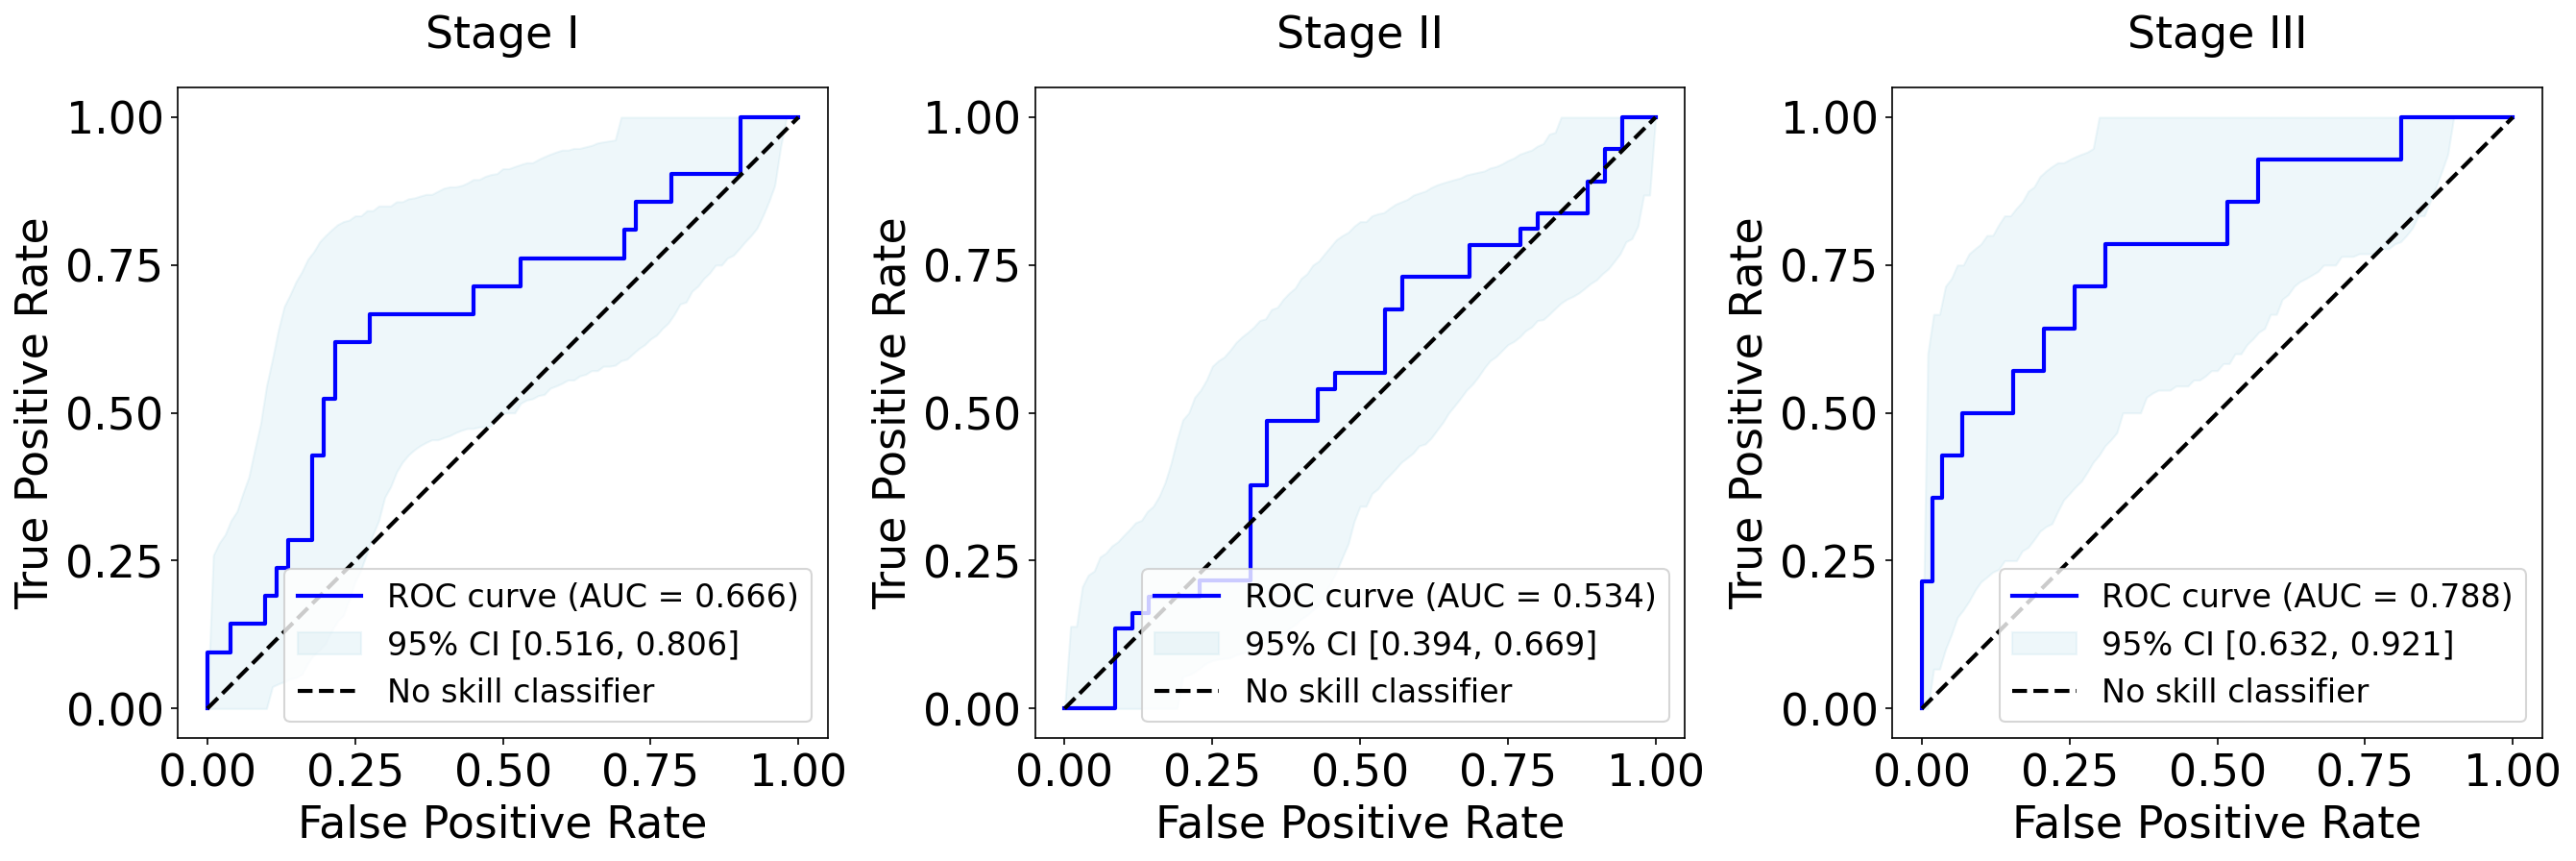

In [32]:
plot_roc_with_saved_bootstrap(bootstrap_samples, biopsy_df_local_test.clinical_stage.values-1, final_pred_ensemble_local_test)

### PR curve with CI - simple interp

In [33]:
def calculate_bootstrap_pr_curve_simple_interp(bootstrap_samples, class_index):
    base_recalls = np.linspace(0, 1, 101)
    precisions = []
    pr_aucs = []

    for sample_y_true, sample_y_pred in tqdm(bootstrap_samples):
        # Binarize the true labels for one-vs-rest classification
        binarized_y_true = (sample_y_true == class_index).astype(int)
        
        # Calculate precision-recall curve
        precision, recall, _ = precision_recall_curve(binarized_y_true, sample_y_pred[:, class_index])
        pr_auc = auc(recall, precision)
        pr_aucs.append(pr_auc)

        precision_interp = np.interp(base_recalls, recall[::-1], precision[::-1])
        precisions.append(precision_interp)

    precisions = np.array(precisions)
    mean_precisions = precisions.mean(axis=0)
    std_precisions = precisions.std(axis=0)
    
    precision_lower = np.percentile(precisions, 2.5, axis=0)
    precision_upper = np.percentile(precisions, 97.5, axis=0)

    # Calculate 95% CI for the PR AUC values
    pr_auc_lower = np.percentile(pr_aucs, 2.5)
    pr_auc_upper = np.percentile(pr_aucs, 97.5)
    
    return base_recalls, precision_lower, precision_upper, mean_precisions, pr_auc_lower, pr_auc_upper

In [34]:
def plot_pr_with_saved_bootstrap_simple_interp(bootstrap_samples, y_true, y_pred):
    if y_pred.shape[1] != 3:
        raise ValueError("The number of classes should be 3")

    if y_pred.shape[0] != y_true.shape[0]:
        raise ValueError("Mismatched shape between y_true and y_pred")

    # One-hot encode y_true if necessary
    if len(y_true.shape) == 1 or y_true.shape[1] != 3:
        y_true = np.eye(3)[y_true]

    fig, axs = plt.subplots(1, 3, figsize=(18, 6), dpi=150)

    for class_ind in range(y_pred.shape[1]):
        # Calculate the original precision-recall curve and AUC for the given class
        precision, recall, _ = precision_recall_curve(y_true[:, class_ind], y_pred[:, class_ind])
        pr_auc = auc(recall, precision)

        # Calculate bootstrap-based precision-recall curves and CIs using saved samples
        base_recalls, precision_lower, precision_upper, mean_precisions, pr_auc_lower, pr_auc_upper = calculate_bootstrap_pr_curve_simple_interp(bootstrap_samples, class_ind)

        axs[class_ind].plot(recall, precision, label=f'PR curve (AP = {pr_auc:.3f})', color='green', lw=2)
        if len(precision_lower) > 0 and len(precision_upper) > 0:  # Check if CI is computed
            axs[class_ind].fill_between(base_recalls, precision_lower, precision_upper, color='lightgreen', alpha=0.2, label=f'95% CI [{pr_auc_lower:.3f}, {pr_auc_upper:.3f}]')
        else:
            print("CI NOT COMPUTED")
            
        ## plot no skill line
        axs[class_ind].hlines(
            y_true[:, class_ind].sum() / y_true[:, class_ind].shape[0], 
            0,
            1, 
            color="black", 
            label="No skill classifier",
            lw=2,
            linestyles='dashed',
            alpha=1.)

        axs[class_ind].axis("square")
        axs[class_ind].set_xlim([-0.05, 1.05])
        axs[class_ind].set_ylim([-0.05, 1.05])
        
        axs[class_ind].set_xlabel('Recall', fontsize=22)
        axs[class_ind].set_ylabel('Precision', fontsize=22)
   
        stage_names = ["I", "II", "III"]
        axs[class_ind].set_title(f'Stage {stage_names[class_ind]}', fontsize=22, pad=20)
        axs[class_ind].legend(fontsize=16)
        
        # Set ticks for both axes
        axs[class_ind].set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
        axs[class_ind].set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
        axs[class_ind].tick_params(axis='both', which='major', labelsize=22)
        axs[class_ind].xaxis.label.set_size(22)
        axs[class_ind].yaxis.label.set_size(22)
        

    plt.tight_layout()
    plt.savefig('sote_paper_figures_rev/pr_curve_with_ci_internal_test_uni_finetuned_rev.png')
    plt.savefig('sote_paper_figures_rev/pr_curve_with_ci_internal_test_uni_finetuned_rev.svg')
    plt.show()

100%|██████████| 10000/10000 [00:05<00:00, 1782.08it/s]


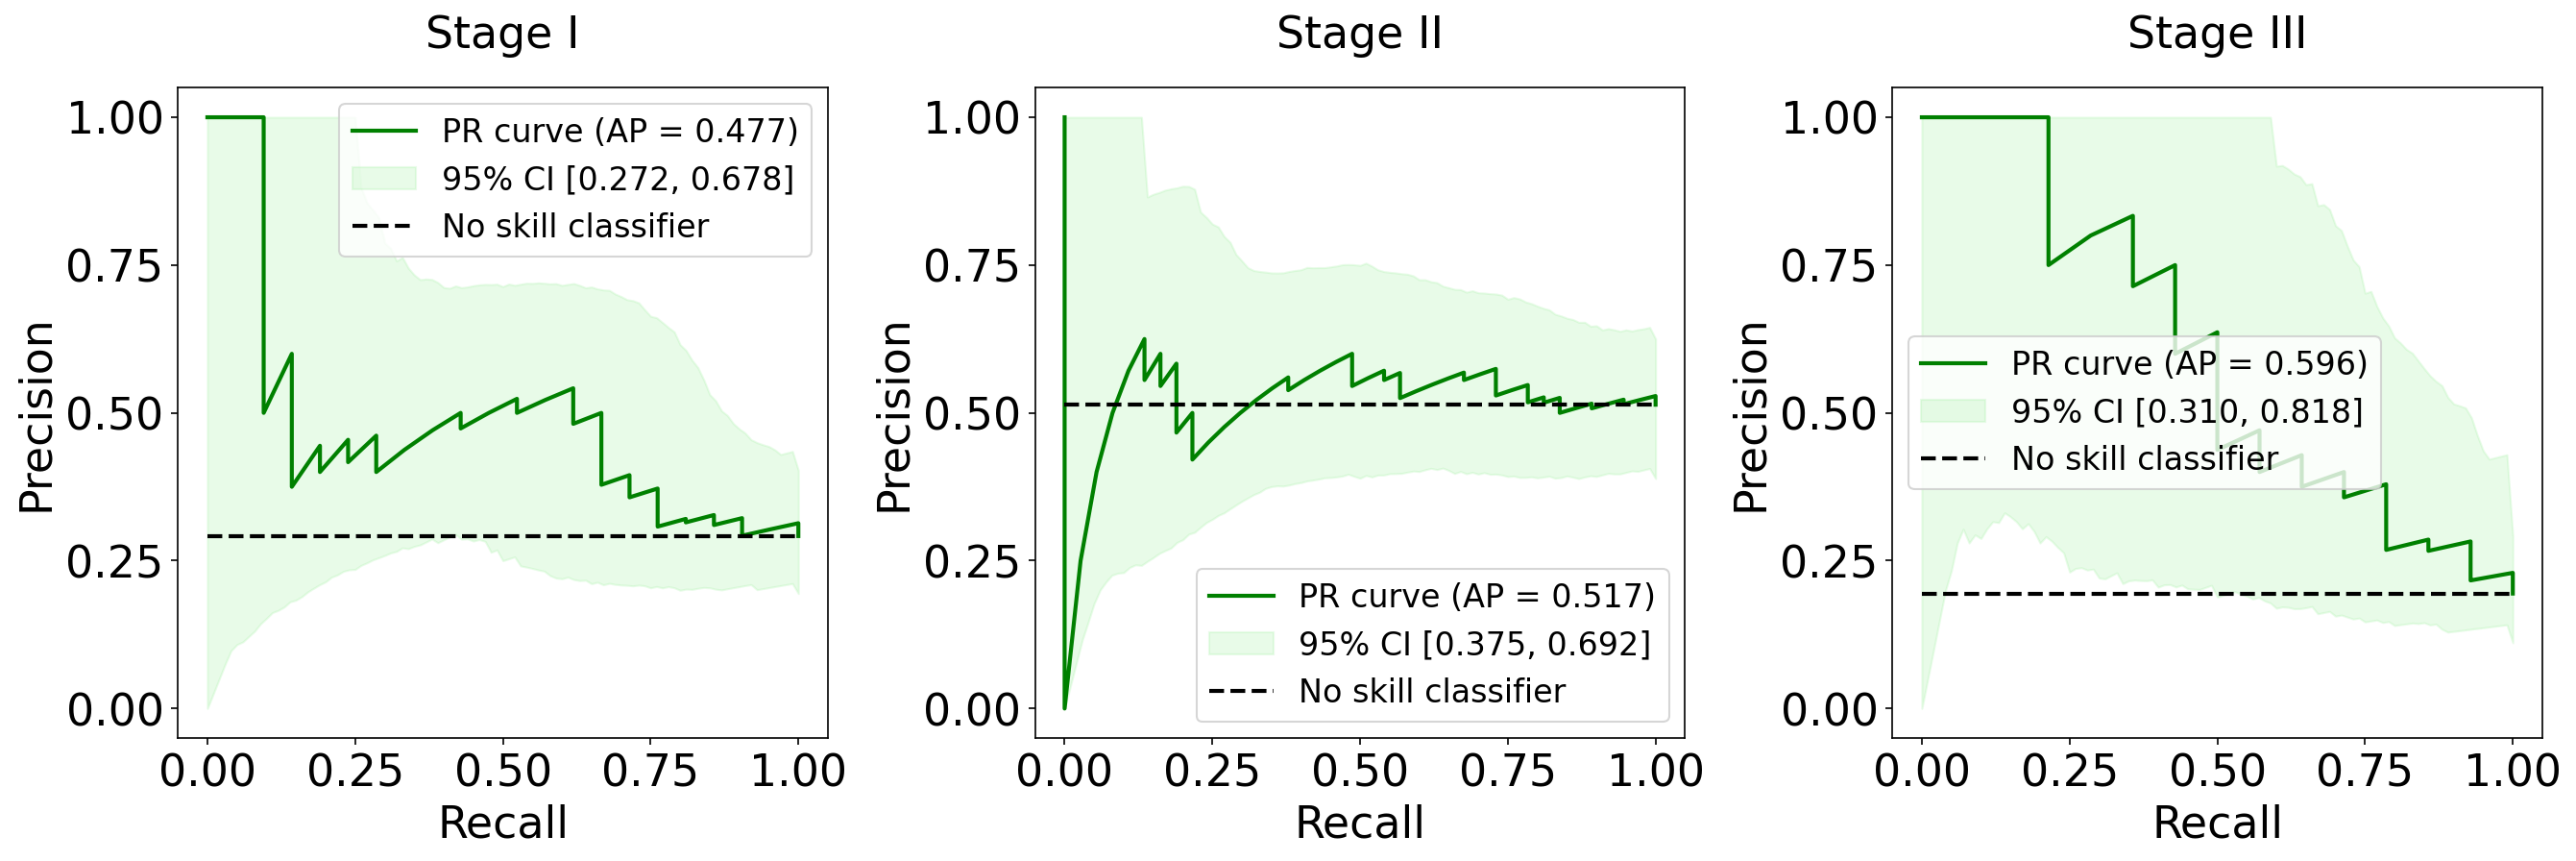

In [35]:
plot_pr_with_saved_bootstrap_simple_interp(bootstrap_samples, biopsy_df_local_test.clinical_stage.values-1, final_pred_ensemble_local_test)

### PR curve with CI - proper interp

### Confusion matrix - default argmax

In [36]:
biopsy_df_local_test.clinical_stage.values.shape, final_pred_ensemble_local_test.shape

((72,), (72, 3))

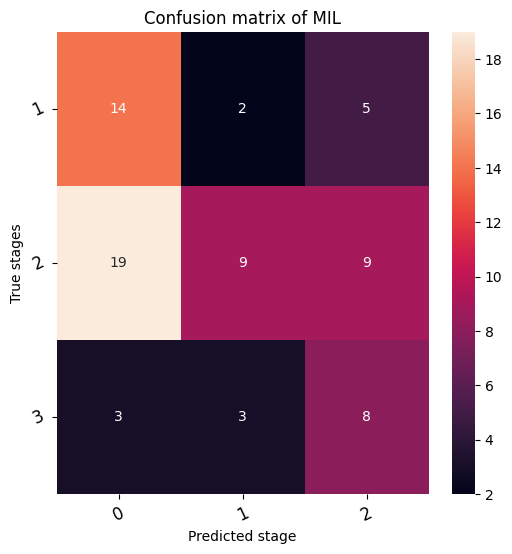

In [37]:
# calculating the confusion matrix
confusion_matrix_initial = pd.crosstab( biopsy_df_local_test.clinical_stage.values, np.argmax( final_pred_ensemble_local_test, axis=1),
                                rownames=['True stages'], colnames=['Predicted stage'] )
#print( confusion_matrix )

confusion_matrix_padded = confusion_matrix_initial.reindex(index=range(1, 4), columns=range(0, 3), fill_value=0)

custom_heatmap = np.round(confusion_matrix_padded,0).astype(int).astype(str) #+ ' ± ' + std_confusion_matrix_tuned.round(0).astype(int).astype(str)


# visualizng it on a heatmap
plt.figure(figsize=(6,6), dpi=100)
plt.title( 'Confusion matrix of MIL')
sns.heatmap(confusion_matrix_padded, annot=True, 
            #xticklabels=np.array(lb.classes_), 
            #yticklabels=np.array(lb.classes_), annot_kws={"size": 20}
           )
plt.tick_params(labelsize=12, rotation=25)
plt.xlabel('Predicted stage')
plt.show()

### Confusion matrix - tuned thresholds before after

In [38]:
final_pred_ensemble_local_test.shape

(72, 3)

In [39]:
# Create an empty list to store confusion matrices
confusion_matrices = []
predicted_labels_test = give_back_hard_label_predictions_with_threshold_tuning(final_pred_ensemble_local_test, thresholds_final)
    
# Calculate the confusion matrix for this set
confusion_matrix = pd.crosstab(biopsy_df_local_test.clinical_stage.values, predicted_labels_test, rownames=['True stages'], colnames=['Predicted stage'])

# Append the confusion matrix to the list
confusion_matrices.append(confusion_matrix)

# Calculate the mean and standard error of the confusion matrices
mean_confusion_matrix_tuned = sum(confusion_matrices) / len(confusion_matrices)
std_confusion_matrix_tuned = np.std(confusion_matrices, axis=0)

# Create a custom heatmap with mean values and overlay standard deviations
custom_heatmap_tuned = np.round(mean_confusion_matrix_tuned,0).astype(int).astype(str) #+ ' ± ' + std_confusion_matrix_tuned.round(0).astype(int).astype(str)
#custom_heatmap = f'{np.round(mean_confusion_matrix,0).astype(int)} $\pm$ {std_confusion_matrix.round(0).astype(int)}'


# Plot the custom heatmap
#plt.figure(figsize=(8, 6), dpi=100)
#sns.heatmap(mean_confusion_matrix_tuned, annot=custom_heatmap_tuned, fmt="", cmap=sns.cm.rocket )#annot_kws={"size": 12})
#plt.tick_params(labelsize=12, rotation=25)
#plt.xlabel('Predicted stage')
#plt.show()

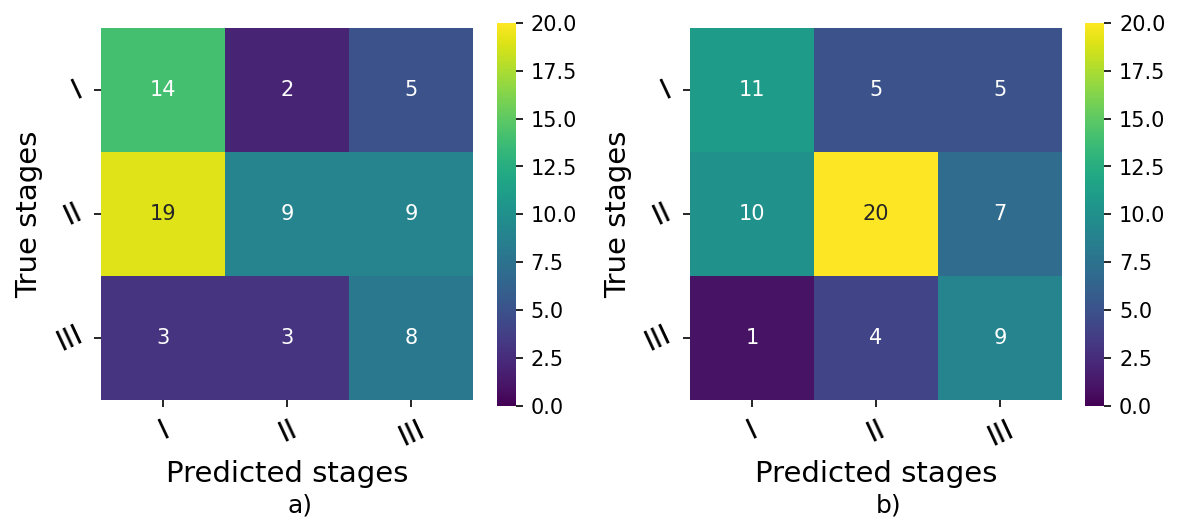

In [40]:
# Compute the maximum value in your confusion matrices
max_value = max(confusion_matrix_padded.values.max(), mean_confusion_matrix_tuned.values.max())

fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=150)

# First subplot
sns.heatmap(confusion_matrix_padded, annot=custom_heatmap, fmt="", cmap="viridis", ax=axes[0], vmin=0, vmax=max_value, cbar_kws={"shrink": 0.75} )
axes[0].set_ylabel('True stages', fontsize=14)
axes[0].set_xlabel('Predicted stages', fontsize=14)
axes[0].tick_params(labelsize=14)
axes[0].set_box_aspect(1)  # Ensures the heatmap is square (with all elements)
# Add more xticks for the first subplot
axes[0].text(0.5, -0.3, 'a)', transform=axes[0].transAxes, fontsize=12)

# Set custom tick labels for x and y axes
axes[0].set_xticklabels(['I', 'II', 'III'], rotation=25)
axes[0].set_yticklabels(['I', 'II', 'III'], rotation=25)

# Second subplot
sns.heatmap(mean_confusion_matrix_tuned, annot=custom_heatmap_tuned, fmt="", cmap="viridis", ax=axes[1], vmin=0, vmax=max_value, cbar_kws={"shrink": 0.75}) 
axes[1].set_ylabel('True stages', fontsize=14)
axes[1].set_xlabel('Predicted stages', fontsize=14)
axes[1].tick_params(labelsize=14)
axes[1].set_box_aspect(1)  # Ensures the heatmap is square (with all elements)
# Add more xticks for the second subplot

axes[1].text(0.5, -0.3, 'b)', transform=axes[1].transAxes, fontsize=12)

# Set custom tick labels for x and y axes
axes[1].set_xticklabels(['I', 'II', 'III'], rotation=25)
axes[1].set_yticklabels(['I', 'II', 'III'], rotation=25)

plt.tight_layout()
#plt.savefig('paper_figures/confmat_internal_test_uni_finetuned_before_after.png')
#plt.savefig('paper_figures/confmat_internal_test_uni_finetuned_before_after.svg', format='svg')
plt.show()

### Confusion matrix - tuned thresholds before after normalized

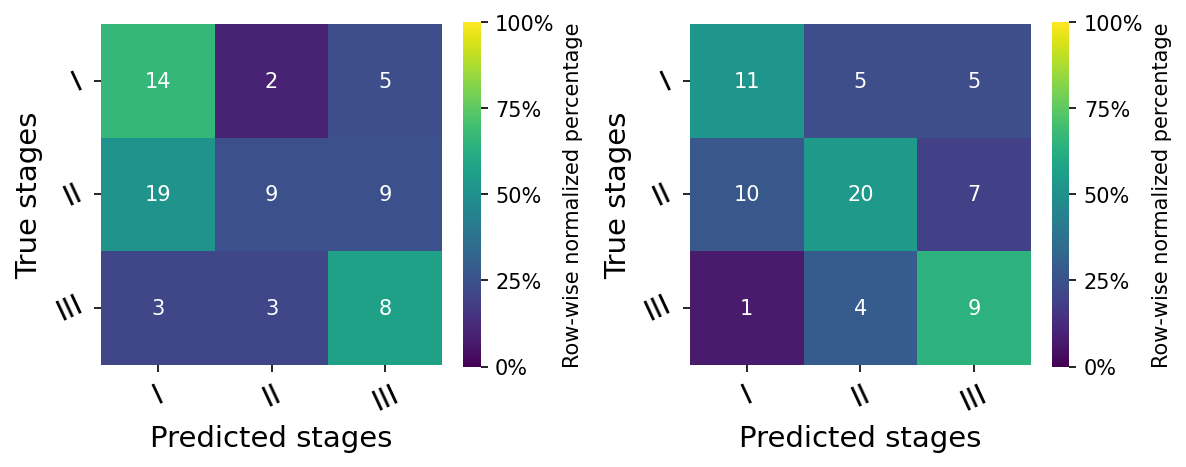

In [41]:
# Normalize confusion matrix (convert to numpy arrays first)
confusion_matrix_normalized = confusion_matrix_padded.values.astype('float') / confusion_matrix_padded.values.sum(axis=1)[:, np.newaxis]
mean_confusion_matrix_normalized = mean_confusion_matrix_tuned.values.astype('float') / mean_confusion_matrix_tuned.values.sum(axis=1)[:, np.newaxis]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=150)

# First subplot (normalized)
sns.heatmap(confusion_matrix_normalized, annot=custom_heatmap, fmt="", cmap='viridis', ax=axes[0], vmin=0, vmax=1, cbar_kws={"shrink": 0.65})
axes[0].set_ylabel('True stages', fontsize=14)
axes[0].set_xlabel('Predicted stages', fontsize=14)
axes[0].tick_params(labelsize=14)
axes[0].set_box_aspect(1)
#axes[0].text(0.5, -0.3, 'a)', transform=axes[0].transAxes, fontsize=12)

# Set custom tick labels for x and y axes
axes[0].set_xticklabels(['I', 'II', 'III'], rotation=25)
axes[0].set_yticklabels(['I', 'II', 'III'], rotation=25)

# Second subplot (normalized)
sns.heatmap(mean_confusion_matrix_normalized, annot=custom_heatmap_tuned, fmt="", cmap='viridis', ax=axes[1], vmin=0, vmax=1, cbar_kws={"shrink": 0.65})
axes[1].set_ylabel('True stages', fontsize=14)
axes[1].set_xlabel('Predicted stages', fontsize=14)
axes[1].tick_params(labelsize=14)
axes[1].set_box_aspect(1)
#axes[1].text(0.5, -0.3, 'b)', transform=axes[1].transAxes, fontsize=12)

# Set custom tick labels for x and y axes
axes[1].set_xticklabels(['I', 'II', 'III'], rotation=25)
axes[1].set_yticklabels(['I', 'II', 'III'], rotation=25)

# Add colorbar labels and fix size for both subplots
for ax in axes:
    cbar = ax.collections[0].colorbar  # Access the colorbar
    cbar.set_label('Row-wise normalized percentage', fontsize=10)
    cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    cbar.ax.tick_params(labelsize=10)  # Adjust tick size
    #cbar.ax.set_aspect(17)  # Adjust aspect ratio of the colorbar to match the heatmap

plt.tight_layout()
#plt.savefig('paper_figures/confmat_internal_test_uni_finetuned_before_after_normalized_with_percentage.png')
#plt.savefig('paper_figures/confmat_internal_test_uni_finetuned_before_after_normalized_with_percentage.svg', format='svg')
plt.show()

### Confusion matrix - tuned thresholds

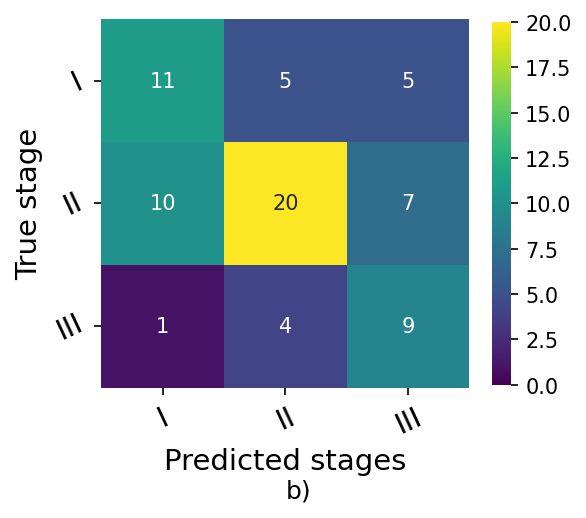

In [42]:
# Compute the maximum value in your confusion matrices
max_value = max(confusion_matrix_padded.values.max(), mean_confusion_matrix_tuned.values.max())

fig, axes = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

# First subplot
sns.heatmap(mean_confusion_matrix_tuned, annot=custom_heatmap_tuned, fmt="", cmap="viridis", ax=axes, vmin=0, vmax=max_value, cbar_kws={"shrink": 0.75} )
axes.set_ylabel('True stage', fontsize=14)
axes.set_xlabel('Predicted stages', fontsize=14)
axes.tick_params(labelsize=14)
axes.set_box_aspect(1)  # Ensures the heatmap is square (with all elements)
# Add more xticks for the second subplot

axes.text(0.5, -0.3, 'b)', transform=axes.transAxes, fontsize=12)

# Set custom tick labels for x and y axes
axes.set_xticklabels(['I', 'II', 'III'], rotation=25)
axes.set_yticklabels(['I', 'II', 'III'], rotation=25)

plt.tight_layout()
#plt.savefig('paper_figures/confmat_internal_test_uni_finetuned.png')
#plt.savefig('paper_figures/confmat_internal_test_uni_finetuned.svg', format='svg')

### Confusion matrix - tuned thresholds normalized

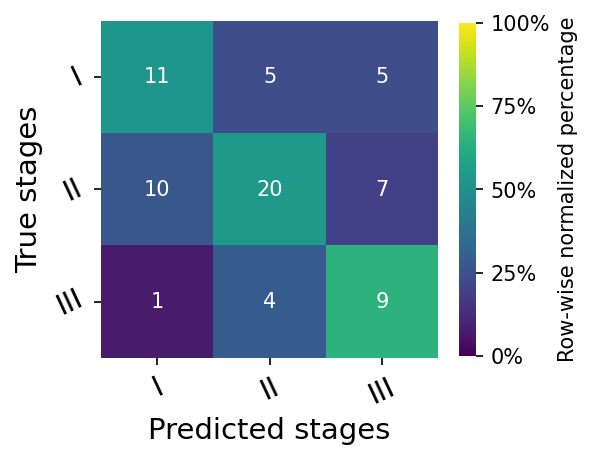

In [43]:
# Normalize confusion matrix (convert to numpy arrays first)
mean_confusion_matrix_normalized = mean_confusion_matrix_tuned.values.astype('float') / mean_confusion_matrix_tuned.values.sum(axis=1)[:, np.newaxis]

# Plot
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# Second subplot (normalized)
sns.heatmap(mean_confusion_matrix_normalized, annot=custom_heatmap_tuned, fmt="", cmap='viridis', ax=ax, vmin=0, vmax=1, cbar_kws={"shrink": 0.65})
ax.set_ylabel('True stages', fontsize=14)
ax.set_xlabel('Predicted stages', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_box_aspect(1)

# Set custom tick labels for x and y axes
ax.set_xticklabels(['I', 'II', 'III'], rotation=25)
ax.set_yticklabels(['I', 'II', 'III'], rotation=25)

# Add colorbar labels and fix size
cbar = ax.collections[0].colorbar  # Access the colorbar
cbar.set_label('Row-wise normalized percentage', fontsize=10)
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
cbar.ax.tick_params(labelsize=10)  # Adjust tick size

plt.tight_layout()

# Save the figure
#plt.savefig('paper_figures/confmat_internal_test_uni_finetuned_after_normalized_with_percentage.png')
#plt.savefig('paper_figures/confmat_internal_test_uni_finetuned_after_normalized_with_percentage.svg', format='svg')

# Show the plot
plt.show()


### Confusion matrix - tuned thresholds normalized - ratios

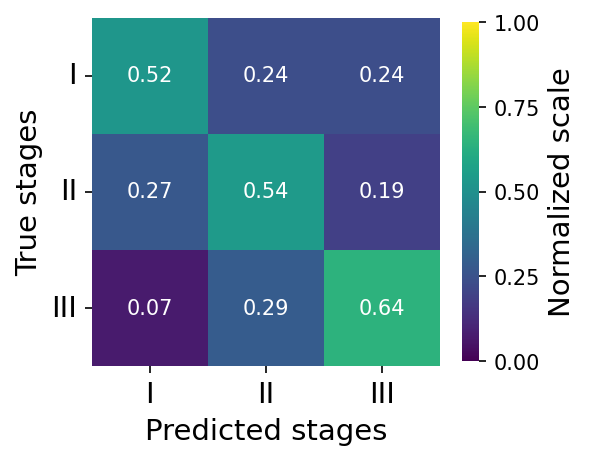

In [44]:
# Normalize confusion matrix (convert to numpy arrays first)
mean_confusion_matrix_normalized = mean_confusion_matrix_tuned.values.astype('float') / mean_confusion_matrix_tuned.values.sum(axis=1)[:, np.newaxis]

# Plot
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# Second subplot (normalized)
sns.heatmap(mean_confusion_matrix_normalized, annot=np.round(mean_confusion_matrix_normalized, 2), fmt="", cmap='viridis', ax=ax, vmin=0, vmax=1, cbar_kws={"shrink": 0.65})
ax.set_ylabel('True stages', fontsize=14)
ax.set_xlabel('Predicted stages', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_box_aspect(1)

# Set custom tick labels for x and y axes
ax.set_xticklabels(['I', 'II', 'III'], rotation=0)
ax.set_yticklabels(['I', 'II', 'III'], rotation=0)

# Add colorbar labels and fix size
cbar = ax.collections[0].colorbar  # Access the colorbar
cbar.set_label('Normalized scale', fontsize=14)
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
cbar.ax.tick_params(labelsize=10)  # Adjust tick size

plt.tight_layout()

# Save the figure
#plt.savefig('paper_figures/confmat_internal_test_uni_finetuned_row_normalized.png')
#plt.savefig('paper_figures/confmat_internal_test_uni_finetuned_row_normalized.svg', format='svg')

# Show the plot
plt.show()


### Confusion matrix - tuned thresholds normalized - ratios and main values

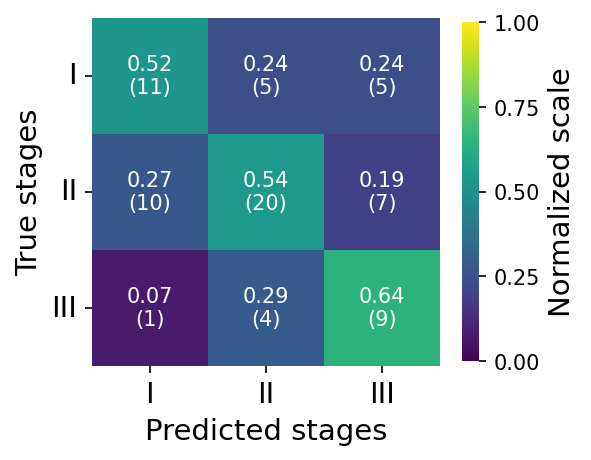

In [45]:
# Normalize confusion matrix (convert to numpy arrays first)
mean_confusion_matrix_normalized = mean_confusion_matrix_tuned.values.astype('float') / mean_confusion_matrix_tuned.values.sum(axis=1, keepdims=True)

# Replace NaN values with zeros (this happens where the sum of rows is zero, like in row 4)
#mean_confusion_matrix_normalized = np.nan_to_num(mean_confusion_matrix_normalized)

# Create custom annotations with percentages as main and actual values in parentheses
custom_annotations = np.empty_like(mean_confusion_matrix_tuned.values, dtype=object)
for i in range(mean_confusion_matrix_tuned.shape[0]):
    for j in range(mean_confusion_matrix_tuned.shape[1]):
        actual_value = int(mean_confusion_matrix_tuned.values[i, j])
        percentage_value = mean_confusion_matrix_normalized[i, j] 
        custom_annotations[i, j] = f"{percentage_value:.2f}\n({actual_value})"

# Plot
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# Heatmap with both percentages and actual values
sns.heatmap(mean_confusion_matrix_normalized, annot=custom_annotations, fmt="", cmap='viridis', ax=ax, vmin=0, vmax=1, cbar_kws={"shrink": 0.65})
ax.set_ylabel('True stages', fontsize=14)
ax.set_xlabel('Predicted stages', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_box_aspect(1)

# Set custom tick labels for x and y axes
ax.set_xticklabels(['I', 'II', 'III'], rotation=0)
ax.set_yticklabels(['I', 'II', 'III'], rotation=0)

# Add colorbar labels and fix size
cbar = ax.collections[0].colorbar  # Access the colorbar
cbar.set_label('Normalized scale', fontsize=14)
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
cbar.ax.tick_params(labelsize=10)  # Adjust tick size

plt.tight_layout()

# Save the figure
plt.savefig('sote_paper_figures_rev/confmat_internal_test_combined_percentages_main_uni_finetuned_rev.png')
plt.savefig('sote_paper_figures_rev/confmat_internal_test_combined_percentages_main_uni_finetuned_rev.svg', format='svg')

# Show the plot
plt.show()

### Confusion matrix - tuned thresholds normalized - ratios and main values - before after

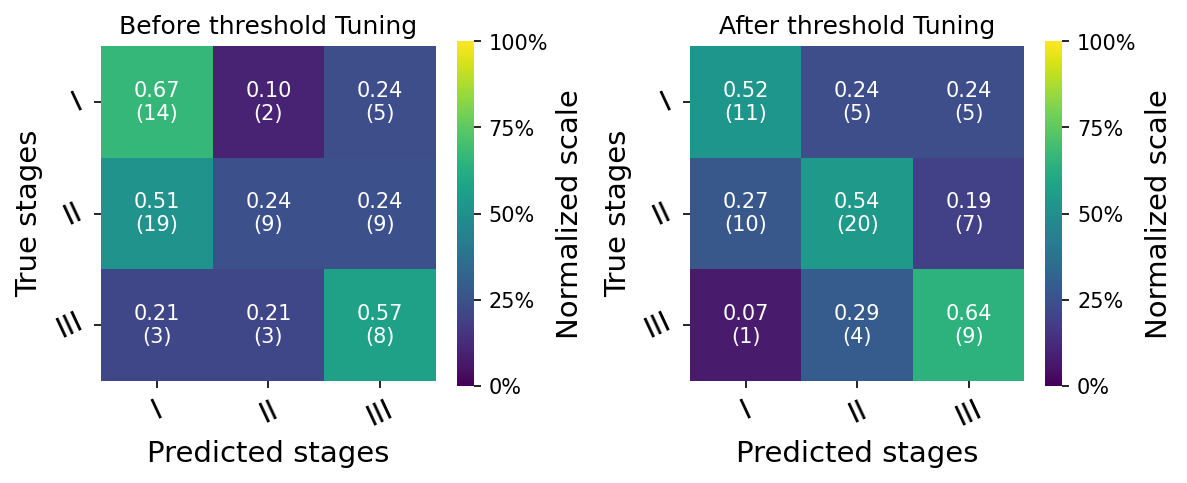

In [46]:
# Normalize confusion matrices (convert to numpy arrays first)
confusion_matrix_normalized = confusion_matrix_padded.values.astype('float') / confusion_matrix_padded.values.sum(axis=1, keepdims=True)
mean_confusion_matrix_normalized = mean_confusion_matrix_tuned.values.astype('float') / mean_confusion_matrix_tuned.values.sum(axis=1, keepdims=True)

# Replace NaN values with zeros (this happens where the sum of rows is zero, like in row 4)
#confusion_matrix_normalized = np.nan_to_num(confusion_matrix_normalized)
#mean_confusion_matrix_normalized = np.nan_to_num(mean_confusion_matrix_normalized)

# Create custom annotations combining actual values and percentages for "before tuning"
custom_annotations_before = np.empty_like(confusion_matrix_padded.values, dtype=object)
for i in range(confusion_matrix_padded.shape[0]):
    for j in range(confusion_matrix_padded.shape[1]):
        actual_value = int(confusion_matrix_padded.values[i, j])
        percentage_value = confusion_matrix_normalized[i, j]
        custom_annotations_before[i, j] = f"{percentage_value:.2f}\n({actual_value})"

# Create custom annotations combining actual values and percentages for "after tuning"
custom_annotations_after = np.empty_like(mean_confusion_matrix_tuned.values, dtype=object)
for i in range(mean_confusion_matrix_tuned.shape[0]):
    for j in range(mean_confusion_matrix_tuned.shape[1]):
        actual_value = int(mean_confusion_matrix_tuned.values[i, j])
        percentage_value = mean_confusion_matrix_normalized[i, j]
        custom_annotations_after[i, j] = f"{percentage_value:.2f}\n({actual_value})"

# Plot
fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=150)

# First subplot (before tuning)
sns.heatmap(confusion_matrix_normalized, annot=custom_annotations_before, fmt="", cmap='viridis', ax=axes[0], vmin=0, vmax=1, cbar_kws={"shrink": 0.65})
axes[0].set_ylabel('True stages', fontsize=14)
axes[0].set_xlabel('Predicted stages', fontsize=14)
axes[0].tick_params(labelsize=14)
axes[0].set_box_aspect(1)
axes[0].set_title('Before threshold Tuning')

# Set custom tick labels for x and y axes
axes[0].set_xticklabels(['I', 'II', 'III'], rotation=25)
axes[0].set_yticklabels(['I', 'II', 'III'], rotation=25)

# Second subplot (after tuning)
sns.heatmap(mean_confusion_matrix_normalized, annot=custom_annotations_after, fmt="", cmap='viridis', ax=axes[1], vmin=0, vmax=1, cbar_kws={"shrink": 0.65})
axes[1].set_ylabel('True stages', fontsize=14)
axes[1].set_xlabel('Predicted stages', fontsize=14)
axes[1].tick_params(labelsize=14)
axes[1].set_box_aspect(1)
axes[1].set_title('After threshold Tuning')

# Set custom tick labels for x and y axes
axes[1].set_xticklabels(['I', 'II', 'III'], rotation=25)
axes[1].set_yticklabels(['I', 'II', 'III'], rotation=25)

# Add colorbar labels and fix size for both subplots
for ax in axes:
    cbar = ax.collections[0].colorbar  # Access the colorbar
    cbar.set_label('Normalized scale', fontsize=14)
    cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    cbar.ax.tick_params(labelsize=10)  # Adjust tick size

# Final plot adjustments and saving
plt.tight_layout()
plt.savefig('sote_paper_figures_rev/confmat_internal_test_combined_percentages_main_before_after_uni_finetuned_rev.png')
plt.savefig('sote_paper_figures_rev/confmat_internal_test_combined_percentages_main_before_after_uni_finetuned_rev.svg', format='svg')
plt.show()